# Autoencodeur masqué (MAE) sur MNIST

Ce notebook implémente :
1. Un **autoencodeur masqué (MAE)** entraîné sur MNIST avec un **masquage par patchs (4×4)**.
2. Des expériences de reconstruction avec différentes probabilités de masquage `p`.
3. Une **classification à l’aide de l’encodeur gelé**, atteignant une erreur inférieure à 10 % avec un classifieur simple.


## Imports et device


In [16]:
!pip install matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 87.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 73.9 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.utils import save_image


In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## Masked MNIST dataset

In [5]:

class MaskedMNIST(Dataset):
    def __init__(self, dataset, p=0.5, patch_size=4):
        self.dataset = dataset
        self.p = p
        self.patch_size = patch_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]  # image: [1,28,28]
        target = image.clone()

        for i in range(0, 28, self.patch_size):
            for j in range(0, 28, self.patch_size):
                if torch.rand(1).item() < self.p:
                    image[:, i:i+self.patch_size, j:j+self.patch_size] = 0.0

        return image, target


## Chargement des données

In [6]:

transform = transforms.ToTensor()
BATCH_SIZE = 128

full_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_base, val_base = random_split(full_train, [train_size, val_size])

train_dataset = MaskedMNIST(train_base, p=0.5)
val_dataset   = MaskedMNIST(val_base, p=0.5)
test_dataset_masked = MaskedMNIST(test_dataset, p=0.5)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset_masked, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 9.91M/9.91M [03:29<00:00, 47.3kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 113kB/s]
100%|██████████| 1.65M/1.65M [00:29<00:00, 55.2kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.38MB/s]


## Modèle du Masked Autoencoder  

In [7]:

class ConvMAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 14x14
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 7x7
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        # 3x3
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 3 * 3),
            nn.Unflatten(1, (128, 3, 3)),

            nn.Upsample(size=(7, 7)),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(size=(14, 14)),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(size=(28, 28)),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


## Entraînement du MAE

In [9]:

model = ConvMAE(latent_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def train_mae(model, epochs=30):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, target in train_loader:
            x, target = x.to(device), target.to(device)
            optimizer.zero_grad()
            out, _ = model(x)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x, target in val_loader:
                x, target = x.to(device), target.to(device)
                out, _ = model(x)
                val_loss += criterion(out, target).item()

        print(f"Epoch {epoch+1}: train={total_loss/len(train_loader):.4f}, val={val_loss/len(val_loader):.4f}")

train_mae(model, epochs=10)


Epoch 1: train=0.0698, val=0.0376
Epoch 2: train=0.0292, val=0.0242
Epoch 3: train=0.0219, val=0.0205
Epoch 4: train=0.0191, val=0.0180
Epoch 5: train=0.0174, val=0.0168
Epoch 6: train=0.0164, val=0.0158
Epoch 7: train=0.0156, val=0.0151
Epoch 8: train=0.0149, val=0.0145
Epoch 9: train=0.0145, val=0.0144
Epoch 10: train=0.0141, val=0.0141


## Reconstruction avec une probabilité de masquage plus élevée


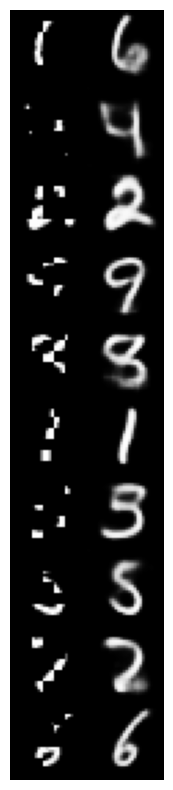

In [13]:
test_dataset_heavy = MaskedMNIST(test_dataset, p=0.7)
test_loader_heavy = DataLoader(test_dataset_heavy, batch_size=10, shuffle=True)

model.eval()

# Suppose x et out ont la forme (batch_size, 1, H, W)
x, target = next(iter(test_loader_heavy))
x = x.to(device)

with torch.no_grad():
    out, _ = model(x)

# On retire la dimension des canaux et on convertit en CPU
x = x.squeeze(1).cpu()   # (batch_size, H, W)
out = out.squeeze(1).cpu()

# On concatène les images du batch horizontalement pour chaque paire (input / reconstruction)
comparison = torch.cat([torch.cat([xi, oi], dim=1) for xi, oi in zip(x, out)], dim=0)

plt.figure(figsize=(10,10))
plt.imshow(comparison, cmap="gray")
plt.axis("off")
plt.show()


## Classification à l’aide de l’encodeur gelé


In [11]:

for p in model.encoder.parameters():
    p.requires_grad = False

class Classifier(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, z):
        return self.net(z)

classifier = Classifier(128).to(device)
clf_optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
clf_criterion = nn.CrossEntropyLoss()


## Entraînement du classifieur


In [14]:

train_clf_loader = DataLoader(full_train, batch_size=128, shuffle=True)
test_clf_loader = DataLoader(test_dataset, batch_size=128)

for epoch in range(10):
    classifier.train()
    total_loss = 0
    for x, y in train_clf_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            z = model.encoder(x)
        logits = classifier(z)
        loss = clf_criterion(logits, y)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()
        total_loss += loss.item()

    correct = 0
    total = 0
    classifier.eval()
    with torch.no_grad():
        for x, y in test_clf_loader:
            x, y = x.to(device), y.to(device)
            z = model.encoder(x)
            preds = classifier(z).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total * 100
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_clf_loader):.4f}, test accuracy={acc:.2f}%")


Epoch 1: loss=0.3150, test accuracy=96.68%
Epoch 2: loss=0.1045, test accuracy=97.37%
Epoch 3: loss=0.0856, test accuracy=97.68%
Epoch 4: loss=0.0737, test accuracy=97.96%
Epoch 5: loss=0.0656, test accuracy=97.89%
Epoch 6: loss=0.0595, test accuracy=98.23%
Epoch 7: loss=0.0545, test accuracy=98.37%
Epoch 8: loss=0.0503, test accuracy=98.19%
Epoch 9: loss=0.0470, test accuracy=98.43%
Epoch 10: loss=0.0448, test accuracy=98.57%


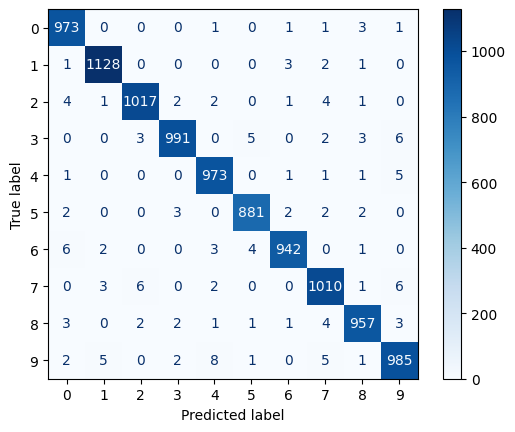

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

classifier.eval()
with torch.no_grad():
    for x, y in test_clf_loader:
        x, y = x.to(device), y.to(device)
        z = model.encoder(x)
        preds = classifier(z).argmax(dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.show()
